## Analysis of the synthetic data using uncertainty estimation approaches 

#### Sonia Laguna - ETH Zurich MSc Thesis
##### Includes all the analysis and plots shown in the MSc report. This document is general for the three uncertainty methods. 

### Functions

In [1]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from skimage.morphology import binary_dilation
import hdf5storage
# import cv2 as cv
import statistics
import matplotlib.colors as colors
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
import matplotlib.transforms as mtrans
from scipy.signal import hilbert
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import scipy
from scipy.stats import spearmanr
from scipy.stats import kendalltau

#### Plotting function 

In [2]:
def plotting_all(experiment,uncert, exp, titles_drop, mat, vn, lbfgs_recon, type, plot = False, samples = 3):
    """
    Plots all qualitative results of each frame, including: 
    SoS reconstruction from uncertainty method, uncertainty estimate, SoS from plain VN, SoS from LBFGS, 
    Confidence map, residual, bmode image
    """
    uncert['mask_dev'] = []
    # The input "samples" marks the number of frames to analyse
    for num in np.linspace(0,uncert['mean'].shape[0] - 1,samples):
        num = int(num)
        
        #Computing different paramers and metrics for latter plots
        #Computing L*Meas
        b = np.ones(np.shape(orig_data['measmnts'][:, num]))
        b[np.isnan(orig_data['measmnts'][:, num])] = 0
        #Computing L*CorrCoeff
        # b = orig_data['CorrCoeff'][:, num].copy()
        # b[np.isnan(orig_data['CorrCoeff'][:, num])] = 0
        
        a = np.matmul(np.transpose(np.abs(orig_data['L'])), b)
        backp = (a.reshape(84, 64, order='F').copy())
        backp = (backp - np.amin(backp[7:,:])) / (np.amax(backp[7:,:]) - np.amin(backp[7:,:]))
        #Computing the masked uncertainty estimate based on the L*Meas
        kk = np.transpose(uncert['stdev'][num, :, 7:]) * (1 - 0.5*backp[7:, :])
        mask_dev = np.mean(kk[np.transpose(uncert['mask_out'][num, :, 7:] == 1)])
        uncert['mask_dev'].append(mask_dev)
         
        if plot:
            #Defining limits for the lookup table
            #vmin_c = np.amin([np.transpose(lbfgs_recon['recon_lbfgs'][num, ...]), uncert['mean'][num, ...],
            #                  vn['recon'][num, ...], 1 / mat['gt_slowness'][ num, ...]])
            #vmax_c = np.amax([np.transpose(lbfgs_recon['recon_lbfgs'][num, ...]), uncert['mean'][num, ...],
            #                  vn['recon'][num, ...], 1 / mat['gt_slowness'][num, ...]])
            vmin_c = 1460
            vmax_c = 1540
            vmin_st = 2
            vmax_st = 20

            #Starting to plot:
            f, axarr = plt.subplots(2, 3, figsize=(10, 10 * uncert['mean'][num, ...].shape[0] / uncert['mean'][num, ...].shape[1]))
            #Mean SoS reconstruction
            a0 = axarr[0, 0].imshow(np.transpose(uncert['mean'][num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            axarr[0, 0].set_title('RMSE: ' + str(np.around(uncert['rmse'][num], decimals=2)) + '\nMean [m/s]',fontsize=13)
            axarr[0, 0].set_xticks([])
            axarr[0, 0].set_yticks([])
            p0 = plt.colorbar(a0, ax=axarr[0, 0], fraction=0.046 * (uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            p0.ax.tick_params(labelsize=10)
            #Uncertainty
            a1 = axarr[0, 1].imshow(np.transpose(uncert['stdev'][num, ...]),cmap= 'hot_r', vmin = vmin_st, vmax = vmax_st)
            axarr[0, 1].set_title('Stdev local: ' + str(np.around(uncert['stdevs'][num], decimals=2)) +'\n St. dev [m/s]',fontsize=13)
            axarr[0, 1].set_xticks([])
            axarr[0, 1].set_yticks([])
            p1 = plt.colorbar(a1, ax=axarr[0, 1], fraction=0.046 * (uncert['mean'][num, ...].shape[1]/
                        uncert['mean'][num, ...].shape[0] ))
            p1.ax.tick_params(labelsize=10)
            #Original gt
            a2 = axarr[1, 0].imshow(np.transpose(1 / mat['gt_slowness'][ num, ...]), cmap ='turbo', vmin = vmin_c, vmax = vmax_c)
            p2 = plt.colorbar(a2, ax=axarr[1, 0], fraction=0.046 * (uncert['mean'][num, ...].shape[1]/
                        uncert['mean'][num, ...].shape[0]))
            axarr[1, 0].set_title('Original SoS [m/s]', fontsize=13)
            axarr[1, 0].set_xticks([])
            axarr[1, 0].set_yticks([])
            p2.ax.tick_params(labelsize=10)
            #L*Meas: Confidence map
            pc = axarr[1, 1].pcolormesh(np.rot90(backp[7:,:],2), norm=colors.PowerNorm(gamma=0.45), cmap='hot_r')
            p3 = plt.colorbar(pc, ax=axarr[1, 1], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[1, 1].set_title('L*Meas', fontsize=13)
            axarr[1, 1].set_xticks([])
            axarr[1, 1].set_yticks([])
            p3.ax.tick_params(labelsize=10)
            #Orig VN SoS
            a4 = axarr[1, 2].imshow(np.transpose(vn['recon'][num, ...]), cmap= 'turbo', vmin = vmin_c, vmax = vmax_c)
            p4 = plt.colorbar(a4, ax=axarr[1, 2], fraction=0.046 * (
                        uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[1, 2].set_title('VN recon [m/s]', fontsize=13)
            axarr[1, 2].set_xticks([])
            axarr[1, 2].set_yticks([])
            p4.ax.tick_params(labelsize=10)
            #LBFGS SoS reconstruction
            a6 = axarr[0, 2].imshow((lbfgs_recon['recon_lbfgs'][num, ...]), cmap= 'turbo', vmin = vmin_c, vmax = vmax_c)
            p6 = plt.colorbar(a6, ax=axarr[0, 2], fraction=0.046 * (
                        uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[0, 2].set_title('LBFGS recon [m/s]', fontsize=13)
            axarr[0, 2].set_xticks([])
            axarr[0, 2].set_yticks([])
            p6.ax.tick_params(labelsize=10)
            #Extras
            #Measurements mask
            # meas =np.ones(np.shape(orig_data['measmnts'][:,num]))
            # meas[np.isnan(orig_data['measmnts'][:,num])] = 0
            # meas = meas.reshape(84,64,15,order='F').copy()
            # a4 = axarr[1, 2].imshow((np.sum(meas,2)), cmap='YlOrRd', vmin = 0, vmax = 6)
            # axarr[1, 2].set_title('Meas mask',fontsize=13)
            # axarr[1, 2].set_xticks([])
            # axarr[1, 2].set_yticks([])
            # p4 = plt.colorbar(a4, ax=axarr[1, 2], fraction=0.046 * (uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            # p4.ax.tick_params(labelsize=10)
            #Pixelwise error
            # a3 = axarr[1, 1].imshow(np.transpose(uncert['residual'][num, ...]), cmap= 'turbo')
            # axarr[1, 1].set_title('Correlation: ' + str(np.around(corr_2[-1], decimals=2)) + '\n Error [m/s]',
            #                       fontsize=13)
            # axarr[1, 1].set_xticks([])
            # axarr[1, 1].set_yticks([])
            # p3 = plt.colorbar(a3, ax=axarr[1, 1], fraction=0.046 * (
            #             uncert['mean'][num, ...].shape[0] / uncert['mean'][num, ...].shape[1]))
            # p3.ax.tick_params(labelsize=10)
            #Measmnts corr coeff
            # meas_1 = orig_data['CorrCoeff_mask'][:, num].copy()
            # meas_1[np.isnan(orig_data['CorrCoeff_mask'][:, num])] = 0
            # meas_1 = meas_1.reshape(84, 64, 6, order='F').copy()
            # a4 = axarr[1, 2].imshow(np.mean(meas_1,2), cmap='YlOrRd', vmin=0, vmax=1)
            # p4 = plt.colorbar(a4, ax=axarr[1, 2], fraction=0.046 * (uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            # axarr[1, 2].set_title('Mean CorrCoeff', fontsize=13)
            # axarr[1, 2].set_xticks([])
            # axarr[1, 2].set_yticks([])
            # p4.ax.tick_params(labelsize=10)
            #Masked stdev
            # a5 = axarr[0, 2].imshow((kk), cmap='hot_r', vmax=20, vmin = 2)
            # axarr[0, 2].set_title(
            #     'Masked stdev: ' + str(np.around(mask_dev, decimals=2)) + '\n St. dev [m/s]',
            #     fontsize=13)
            # axarr[0, 2].set_xticks([])
            # axarr[0, 2].set_yticks([])
            # p5 = plt.colorbar(a5, ax=axarr[0, 2], fraction=0.046 * (
            #         uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            # p5.ax.tick_params(labelsize=10)
            # f.subplots_adjust(hspace=-0.3)
            f.subplots_adjust(wspace=0.3)
            f.suptitle(experiment[0])
            plt.show()
    return uncert

#### Sample plots function

In [3]:
def sample_plots(experiment,samples, mat,uncert,vn):
    """
        Plots different examples of sampled frames
        Args: 
            -experiment: Label of the experiment
            -samples: Number of frames to iterate over
            -mat: Dictionary with ground truth data
            -uncert: Dictionary including samples, mean reconstruction, uncertainty and inclusion masks 
            -vn: Dictionary with reconstruciton of the plain VN
    """
    if samples > 0:
        ind = []
        rmse_sub = []
        
        #Ranking frames based on RMSE
        for n in range(uncert['samples'].shape[0]):
            rmse = RMSE_single(mat['gt_slowness'][...], uncert['samples'][n], uncert['mask_out'])
            for m in range(uncert['samples'].shape[1]):
                if n == 0:
                    rmse_sub.append([])
                rmse_sub[m].append(rmse[m])
        for m in range(uncert['samples'].shape[1]):
            ind.append(sorted(range(len(rmse_sub[m])), key=lambda k: rmse_sub[m][k]))
#         print('Order RMSEs experiment number, from lowest to highest: ', ind)
        
        for num in np.linspace(0, uncert['mean'].shape[0] - 1, samples):
            num = int(num)
            vmin_c = np.amin([uncert['mean'][num, ...], vn['recon'][num, ...], 1 / mat['gt_slowness'][num, ...]])
            vmax_c = np.amax([ uncert['mean'][num, ...], vn['recon'][num, ...], 1 / mat['gt_slowness'][num, ...]])
            # vmin_c = 1460
            # vmax_c = 1540
            #Plotting
            f, axarr = plt.subplots(2, 4, figsize=(10, 5 * uncert['mean'][num, ...].shape[0] / uncert['mean'][num, ...].shape[1]))
            #Reconstruction mean
            a0 = axarr[0, 0].imshow(np.transpose(uncert['mean'][num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            axarr[0, 0].set_title('Mean [m/s]', fontsize=13)
            axarr[0, 0].set_xticks([])
            axarr[0, 0].set_yticks([])
            p0 = plt.colorbar(a0, ax=axarr[0, 0], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            p0.ax.tick_params(labelsize=10)
            #Uncertainty
            a1 = axarr[0, 1].imshow(np.transpose(uncert['stdev'][num, ...]), cmap='hot_r')
            axarr[0, 1].set_title('St. dev [m/s]',
                fontsize=13)
            axarr[0, 1].set_xticks([])
            axarr[0, 1].set_yticks([])
            p1 = plt.colorbar(a1, ax=axarr[0, 1], fraction=0.046 * (uncert['mean'][num, ...].shape[1] /uncert['mean'][num, ...].shape[0]))
            p1.ax.tick_params(labelsize=10)
            #Original ground truth SoS
            a2 = axarr[1, 0].imshow(np.transpose(1 / mat['gt_slowness'][num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p2 = plt.colorbar(a2, ax=axarr[1, 0], fraction=0.046 * (uncert['mean'][num, ...].shape[1] /
                                                                    uncert['mean'][num, ...].shape[0]))
            axarr[1, 0].set_title('Original SoS [m/s]', fontsize=13)
            axarr[1, 0].set_xticks([])
            axarr[1, 0].set_yticks([])
            p2.ax.tick_params(labelsize=10)
            #Max RMSE sample
            a3 = axarr[1, 1].imshow(np.transpose(uncert['samples'][ind[num][len(ind[num])-1],num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p3 = plt.colorbar(a3, ax=axarr[1, 1], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[1, 1].set_title('Max rmse ' + str(np.around(rmse_sub[num][ind[num][len(ind[num])-1]],decimals=2)) + 'exp ' + str(ind[num][len(ind[num])-1]), fontsize=13)
            axarr[1, 1].set_xticks([])
            axarr[1, 1].set_yticks([])
            p3.ax.tick_params(labelsize=10)
            #Min RMSE sample
            a4 = axarr[0, 2].imshow(np.transpose(uncert['samples'][ind[num][0], num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p4 = plt.colorbar(a4, ax=axarr[0, 2], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[0, 2].set_title('Min rmse ' + str(np.around(rmse_sub[num][ind[num][0]],decimals = 2)) + ' exp ' + str(ind[num][0]), fontsize=13)
            axarr[0, 2].set_xticks([])
            axarr[0, 2].set_yticks([])
            p4.ax.tick_params(labelsize=10)
            #0.25 RMSE sample
            a5 = axarr[0, 3].imshow(np.transpose(uncert['samples'][ind[num][int(0.25*(len(ind[num])-1))],num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p5 = plt.colorbar(a5, ax=axarr[0, 3], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))

            axarr[0, 3].set_title('0.25 rmse ' + str(np.around(rmse_sub[num][ind[num][int(0.25*(len(ind[num])-1))]],decimals=2)) + ' exp ' + str(ind[num][int(0.25*(len(ind[num])-1))]), fontsize=13)
            axarr[0, 3].set_xticks([])
            axarr[0, 3].set_yticks([])
            p5.ax.tick_params(labelsize=10)
            #0.5 RMSE sample
            a6 = axarr[1, 3].imshow(np.transpose(uncert['samples'][ind[num][int(0.5*(len(ind[num])-1))],num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p6 = plt.colorbar(a6, ax=axarr[1, 3], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[1, 3].set_title('0.5 rmse ' + str(
                    np.around(rmse_sub[num][ind[num][int(0.5 * (len(ind[num]) - 1))]], decimals=2)) + ' exp ' + str(
                    ind[num][int(0.5 * (len(ind[num]) - 1))]), fontsize=13)
            axarr[1, 3].set_xticks([])
            axarr[1, 3].set_yticks([])
            p6.ax.tick_params(labelsize=10)
            #0.75 RMSE sample
            a7 = axarr[1, 2].imshow(np.transpose(uncert['samples'][ind[num][int(0.75*(len(ind[num])-1))],num, ...]), cmap='turbo', vmin=vmin_c, vmax=vmax_c)
            p7 = plt.colorbar(a7, ax=axarr[1, 2], fraction=0.046 * (
                    uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            axarr[1, 2].set_title('0.75 rmse ' + str(np.around(rmse_sub[num][ind[num][int(0.75*(len(ind[num])-1))]],decimals = 2))+ ' exp ' + str(ind[num][int(0.75*(len(ind[num])-1))]), fontsize=13)
            axarr[1, 2].set_xticks([])
            axarr[1, 2].set_yticks([])
            p7.ax.tick_params(labelsize=10)
            # a4 = axarr[0, 2].imshow(np.transpose(uncert['median'][num, ...]), cmap='turbo', vmin=vmin_c,
            #                         vmax=vmax_c)
            # p4 = plt.colorbar(a4, ax=axarr[0, 2], fraction=0.046 * (
            #         uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            # axarr[0, 2].set_title('Median [m/s]')
            # axarr[0, 2].set_xticks([])
            # axarr[0, 2].set_yticks([])
            # p4.ax.tick_params(labelsize=10)
            
            # mode = scipy.stats.mode(uncert['samples'][:, num, :], axis=0)
            # a5 = axarr[0, 3].imshow(np.transpose(mode.mode[0,...]), cmap='turbo', vmin=vmin_c,
            #                         vmax=vmax_c)
            # p5 = plt.colorbar(a5, ax=axarr[0, 3], fraction=0.046 * (
            #         uncert['mean'][num, ...].shape[1] / uncert['mean'][num, ...].shape[0]))
            # axarr[0, 3].set_title('Mode [m/s]')
            # axarr[0, 3].set_xticks([])
            # axarr[0, 3].set_yticks([])
            # p5.ax.tick_params(labelsize=10)
            f.subplots_adjust(wspace=0.3)
            f.suptitle(experiment[0])
            plt.show()

#### RMSE computation

In [4]:
def RMSE_duo(img, recon, lbfgs):
    """
    Args:
        img: Ground truth img
        recon: Reconstructed VN
        lbfgs: Reconstructed LBFGS

    Returns: RMSE
    """
    RMSEvn = []
    RMSElbfgs = []
    for p in range(img.shape[0]):
        xtrue = 1 / img[p, ...]
        recon_vn = recon[p, ...]
        recon_l = lbfgs[p, ...]
        RMSEvn.append(np.sqrt(np.mean(np.power(recon_vn - xtrue, 2))))
        RMSElbfgs.append(np.sqrt(np.mean(np.power(np.transpose(recon_l) - xtrue, 2))))

    return RMSEvn, RMSElbfgs
def RMSE_single(img, recon, mask):
    """
    Args:
        img: Ground truth img
        recon: Reconstructed

    Returns: RMSE
    """
    RMSErecon = []
    for p in range(img.shape[0]):
        # xtrue = 1 / img[p, ...]
        # recon_s = recon[p, ...]

        xtrue = 1 / img[p, mask[p, ...] == 1]
        recon_s = recon[p, mask[p, ...] == 1]
        RMSErecon.append(np.sqrt(np.mean(np.power(recon_s - xtrue, 2))) )

    return RMSErecon
def RMSE_single_tot(img, recon):
    """
    Args:
        img: Ground truth img
        recon: Reconstructed

    Returns: RMSE
    """
    RMSErecon = []
    for p in range(img.shape[0]):
        xtrue = 1 / img[p, ...]
        recon_s = recon[p, ...]
        RMSErecon.append(np.sqrt(np.mean(np.power(recon_s - xtrue, 2))) )

    return RMSErecon

### Creating masks

In [5]:
def mask_creator(mat, uncert, sim_old, sim_IC, MS): 
    """
    Creates the masks of sythetic data based on thresholding the ground truth
    Computes the local uncertainties at the inclusion locations
    -sim_old: Refers to the test set of MS data if MS and of VS in not MS
    -sim_IC: Refers to the test set created for the varying contrast in IC experiment
    """
    for j in range(uncert['stdev'].shape[0]):
        if sim_old and MS:
            if j in [0,1,2,3,4,5,6,7,8,15,16,17,18,19,22,23,24,25,26,27,28,29,30,31]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1528.])
                if j is 0:
                    mask_sim = (1 / mat['gt_slowness'][j, ...] >= 1528.).astype(int)
                    mask_sim = mask_sim[None, ...]
                else:
                    mask_sim = np.concatenate(
                        (mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1528.).astype(int), 0)))
            elif j in [9,10,11,12,13,14]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1492.])
                mask_sim = np.concatenate(
                    (mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1492.).astype(int), 0)))
            elif j in [20,21]:
                pre = (1 / mat['gt_slowness'][j, ...] >= 1528.).astype(int)
                pre[:20,:] = 0
                pre[40:,:] = 0
                pre[:,60:] = 0
                mask_sim = np.concatenate((mask_sim, np.expand_dims(pre, 0)))
                stdv_part = np.mean(uncert['stdev'][j, pre == 1])
        elif sim_old and not MS:
            if j in [29,23,17]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1590.])
                mask_sim = np.concatenate(
                    (mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1590.).astype(int), 0)))
            if j in [21,20,16]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1530.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1530.).astype(int), 0)))
            if j in [18,14]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1520.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1520.).astype(int), 0)))
            if j in [3]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1500.])
                mask_sim = np.concatenate((mask_sim,np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1500.).astype(int), 0)))
            if j in [13]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1466.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1466.).astype(int), 0)))
            elif j in [28]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1480.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1480.).astype(int), 0)))
            elif j in [27,25,8,5]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1570.])
                mask_sim = np.concatenate((mask_sim,np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1570.).astype(int), 0)))
            elif j in [12]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1590.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims(
                    (1 / mat['gt_slowness'][j, ...] >= 1590.).astype(int), 0)))
            elif j in [11,9,4,1,0]:
                if j is 0:
                    mask_sim = (1 / mat['gt_slowness'][j, ...] >= 1520.).astype(int)
                    mask_sim = mask_sim[None, ...]
                else:
                    mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1520.).astype(int), 0)))
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1520.])
            elif j in [10,7]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1500.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1500.).astype(int), 0)))
            elif j in [22,19,15]:
                stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1540.])
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1540.).astype(int), 0)))
            elif j in [26,24,6,2]:
                stdv_part = np.nan
                mask_sim = np.concatenate((mask_sim, np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1590.).astype(int), 0)))
        elif sim_IC:
            stdv_part = np.mean(uncert['stdev'][j, 1 / mat['gt_slowness'][0, ...] >= (1498. + (0 + 1) * 5)])
            if j is 0:
                mask_sim = (1 / mat['gt_slowness'][j, ...] >= (1498. + (j+1)*5)).astype(int)
                mask_sim = mask_sim[None, ...]
            if j >0:
                mask_sim = np.concatenate((mask_sim,np.expand_dims((1 / mat['gt_slowness'][0, ...] >= (1498. + (0+1)*5)).astype(int), 0)))
        else:
            #This is the data for the validation MS data (first 50 samples)
            if j is 0:
                mask_sim = (1 / mat['gt_slowness'][j, ...] >= 1590).astype(int)
                mask_sim = mask_sim[None, ...]
                stdv_part = np.mean(
                 uncert['stdev'][j, 1 / mat['gt_slowness'][0, ...] >= 1590])

            elif j in [1,4,5,41,48,49]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1505])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1505).astype(int),
                                    0)))
            elif j in [42]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1490])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1490).astype(int),
                                    0)))
            elif j in [12,36,38]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1520])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1520).astype(int),
                                    0)))
            elif j in [27,30]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1525])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1525).astype(int),
                                    0)))
            elif j in [43]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1560])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1560).astype(int),
                                    0)))
            elif j in [16,23,25]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] <= 1570])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] <= 1570).astype(int),
                                    0)))
            elif j in [2,3,7,11,19,28]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1505])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1505).astype(int),
                                    0)))
            elif j in [6,17,24]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1535])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1535).astype(int),
                                    0)))
            elif j in [13,26]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1485])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1485).astype(int),
                                    0)))
            elif j in [14,29,37]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1465])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1465).astype(int),
                                    0)))
            elif j in [22,46,47,50]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1525])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1525).astype(int),
                                    0)))
            elif j in [15,32,34]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1555])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1555).astype(int),
                                    0)))
            elif j in [8,9,10,18,39,40]:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1585])
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][j, ...] >= 1585).astype(int),
                                    0)))
            elif j in [20,21,31,33,35,44,45]:
                stdv_part = np.nan
                mask_sim = np.concatenate(
                    (mask_sim,
                     np.expand_dims((1 / mat['gt_slowness'][0, ...] >= 1590).astype(int),0)))
            else:
                stdv_part = np.mean(
                    uncert['stdev'][j, 1 / mat['gt_slowness'][j, ...] >= 1555])
                mask_sim = np.concatenate(
                    (mask_sim,np.expand_dims((1 / mat['gt_slowness'][15, ...] >= 1555).astype(int),
                                    0)))
        stdevs.append(stdv_part)
    return stdevs, mask_sim

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_24813/1615746539.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if j is 0:
/tmp/ipykernel_24813/1615746539.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if j is 0:
/tmp/ipykernel_24813/1615746539.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if j is 0:
/tmp/ipykernel_24813/1615746539.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if j is 0:


## Main: Starting analysis

### Input configurations

In [6]:
sim_old = True
sim_IC = False
dir_runs = '/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/'
type = 0 #Make a for loop here if you want to compare more, i.e. {eval-vn_1200, 100_eval-vn-1200,...}
docs = ['eval-vn-120000']
experiment = [''] #Identifier of the experiment

#### Loading data paths

In [7]:
MS = True #Marker to select Virtual Source or Multistatic data
# filename = ['test-syn-0.0-0.0-test-train_VS_15comb_fullpipeline_30.mat'] #File under analysis
#filename = ['test-syn-0.0-0.1-patchy-IC_fromVS_toMS_30_imgs.mat']
#filename = ['test-syn-0.0-0.1-patchy-train_VS_15comb_IC_30.mat']
# filename = ['test-syn-0.0-0.0-patchy-val_MS_6comb.mat']
# filename = ['test-syn-0.0-0.0-test-fullpipeline_big_32.mat']
# filename = ['test-syn-0.0-0.0-test-fullpipeline_testset_6comb_32_imgs.mat']
# filename = ['test-syn-0.0-0.0-test-fullpipeline_testset_6comb_32_imgs_newmask.mat']
# filename = ['test-syn-0.0-0.0-patchy-new_test_syn.mat']
filename = ['test-syn-0.0-0.1-patchy-testset_ideal_MS_32_imgs.mat']
# filename = ['test-syn-0.0-0.5-patchy-testset_ideal_MS_32_imgs.mat']
# filename = ['test-syn-0.0-0.9-patchy-testset_ideal_MS_32_imgs.mat']
# filename = ['test-syn-0.0-test-fukuda_1_imgs.mat']

# orig_data_path = 'VS/train_VS_15comb_fullpipeline_30.mat' #Original file to load parameters
orig_data_path = 'test/testset_ideal_MS_32_imgs.mat'

filename_lbfgs = filename #File as saved in the lbfgs folder
#filename_lbfgs =['test-syn-0.0-0.1-patchy-train_VS_15comb_IC_30.mat']

# gt = '4_ICFP_reg1e5_tau5_VS' # Name of the model corresponding to the plain VN
gt = '4_ICFP_reg1e5_tau5'

#### MC Dropout

In [ ]:
"""
Run this cell to create results using MC dropout
"""
titles_drop = ['K0.5'] 
exps = ['4_ICFP_reg1e5_tau5_dropK0.5']
# exps = ['4_ICFP_reg1e5_tau5_dropK0.5_L2_VS']

#### Bayesian Variational Inference

In [ ]:
"""
Run this cell to create results using Bayesian Variational Inference
"""
titles_drop = ['a-1b-1']
exps = ['4_ICFP_reg1e5_tau5_KLa-1b-1_L2_VS']

#### Ensembles

In [8]:
"""
Run this cell to create results using ensembles method
"""
titles_drop = ['ensembles']
exps = [ #Input models desired for ensembles
      '4_ICFP_reg1e5_tau5_5filt_20lay',
      '4_ICFP_reg1e5_tau5_8filt_25lay',
      '4_ICFP_reg1e5_tau5_8filt_15lay',
      '4_ICFP_reg1e5_tau5_8filt_20lay',
     '4_ICFP_reg1e5_tau5_16filt_25lay',
     '4_ICFP_reg1e5_tau5_16filt_15lay',
     '4_ICFP_reg1e5_tau5_16filt_20lay',
     '4_ICFP_reg1e5_tau5_32filt_25lay',
     '4_ICFP_reg1e5_tau5_32filt_15lay',
     '4_ICFP_reg1e6_tau5',
     '4_ICFP_reg1e5_tau.25',
     '4_ICFP_reg1e5_tau2.5_L2',
     '4_ICFP_reg1e5_tau5',
     '4_ICFP_reg1e5_tau5_L2'
     ]

### Initialization

In [9]:
titles = []
RMSEdrop = []
RMSEdrop_tot = []
stdevs = []
stdevs_mean = []
CNR_tot = []
CNR_tot_gt = []
CNR_VN = []
CNR_lbfgs = []
stdev_tot = []
stdev_loc_tot = []
stdevs_big = []

In [10]:
uncert = {'mean': [], 'stdev': [], 'samples': []}

### Loading all data

####  Bayesian Variational Inference and MC dropout

In [ ]:
"""
Run this cell to create results using MC dropout or Bayesian Variational Inference
"""
exp = 0

dir = os.path.join(dir_runs, exps[exp], docs[type])
mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))

vn_path = os.path.join(dir_runs, gt, docs[type], filename[0])
vn = hdf5storage.loadmat(vn_path)

orig_data = hdf5storage.loadmat(os.path.join('/scratch_net/biwidl307/sonia/data_original/',orig_data_path))
lbfgs_path = '/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/lbfgs/lbfgs-' + filename_lbfgs[0]
lbfgs_recon = hdf5storage.loadmat(lbfgs_path)

#To have the same setting as ensembles
mat['gt_slowness'] = mat['gt_slowness'][0,...]
uncert['samples'] = mat['recon']

#### Deep Ensembles

In [11]:
"""
Run this cell to create results using ensembles method
"""
vn_path = os.path.join(dir_runs, gt, docs[type],filename[0])
vn = hdf5storage.loadmat(vn_path)

orig_data = hdf5storage.loadmat(os.path.join('/scratch_net/biwidl307/sonia/data_original/',orig_data_path))

lbfgs_path = '/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/lbfgs/lbfgs-' + filename_lbfgs[0]
lbfgs_recon = hdf5storage.loadmat(lbfgs_path)
#Loading all ensemble combinations
for exp in range(len(exps)):
    dir = os.path.join(dir_runs, exps[exp], docs[type])
    mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))
    if np.size(uncert['samples']) == 0:
        uncert['samples'] = mat['recon'][None,...]
    else:
        uncert['samples'] = np.concatenate((uncert['samples'], mat['recon'][None,...]))

### Summary statistics reconstruction

In [12]:
uncert['mean'] = np.mean(uncert['samples'], axis=0)
uncert['stdev'] = np.std(uncert['samples'], axis=0)

### Creating data: masks, init stdev

In [13]:
stdevs, mask_sim = mask_creator(mat, uncert, sim_old, sim_IC, MS)
stdevs_mean = np.mean(uncert['stdev'], axis=(1, 2))
uncert['mask_sim'] = mask_sim.copy()
uncert['mask_out'] = mask_sim.copy()

### Creating metrics: uncertainties, ΔSoSs, residual, RMSE

In [14]:
for m in range(mask_sim.shape[0]):
    pos = np.where(mask_sim[m,...] == 1)
    for i in range(len(pos[0])):
        #Making the masks slightly bigger, experimentally tested
        uncert['mask_out'][m, pos[0][i] - 2:pos[0][i] + 2, pos[1][i] - 2:pos[1][i] + 2] = 1    
    stdevs_big.append(np.mean(uncert['stdev'][m, uncert['mask_out'][m, ...] == 1]))
    #The line below normalizes the uncertainty, results seen in the MSc report
    # stdevs_big.append(np.mean(uncert['stdev'][m, uncert['mask_out'][m, ...] == 1])/np.mean(uncert['mean'][m, mask_sim[m, ...] == 1]))
    
    #Computing metrics SoS
    pre = uncert['mean'][m, ...]
    sig_in = np.mean((pre)[np.where((uncert['mask_out'][m,...]) == 1)])
    sig_out = np.mean((pre)[np.where(uncert['mask_out'][m,...] == 0)])
    dev_in = np.std((pre)[np.where(uncert['mask_out'][m, ...] == 1)])
    # stdevs_big.append(np.mean(uncert['stdev'][m, uncert['mask_out'][m, ...] == 1]) /np.abs(sig_in - sig_out))

    CNR = np.abs(sig_in - sig_out) #dSoS
    # CNR = sig_in/dev_in #SNR
    CNR_tot.append(CNR)

    # Computing metrics of the gt data
    pre = 1 / mat['gt_slowness'][ m, ...]
    sig_in = np.mean((pre)[np.where((uncert['mask_out'][m, ...]) == 1)])
    sig_out = np.mean((pre)[np.where(uncert['mask_out'][m, ...] == 0)])
    dev_in = np.std((pre)[np.where(uncert['mask_out'][m, ...] == 1)])
    # CNR = np.abs(sig_in - sig_out)/dev_out #CNR
    CNR = np.abs(sig_in - sig_out) #dSoS
    # CNR = sig_in/dev_in #SNR
    CNR_tot_gt.append(CNR)

#Logging parameters
#dSoSs
uncert['CNR'] = CNR_tot.copy()
uncert['CNR_gt'] = CNR_tot_gt.copy()
for kk in range(len(stdevs)):
    if np.isnan(stdevs[kk]): #Check for cases in which the ground truth does not contain inclusion
        stdevs_big[kk] = np.nan
stdevs = stdevs_big
#Uncertainties
uncert['stdevs_mean'] = stdevs_mean
uncert['stdevs'] = stdevs
#Pixelwise error computation
uncert['residual'] = np.abs(1/mat['gt_slowness'][...] - uncert['mean'])
#Computing RMSE
RMSEdrop.append(RMSE_single(mat['gt_slowness'][...], uncert['mean'], uncert['mask_out']))
uncert['rmse'] = RMSEdrop[0]
RMSEdrop_tot.append(RMSE_single_tot(mat['gt_slowness'][...], uncert['mean']))
RMSEvn, RMSElbfgs = RMSE_duo(mat['gt_slowness'][ ...], vn['recon'], lbfgs_recon['recon_lbfgs'])

# RMSE_tot[docs[type]] = RMSEdrop.copy()

RMSEdrop_tot.append(RMSEvn)
RMSEdrop_tot.append(RMSElbfgs)
titles.append(titles_drop[0])
titles.append('VN')
titles.append('LBFGS')

### Analysing ensemble of data sample-wise

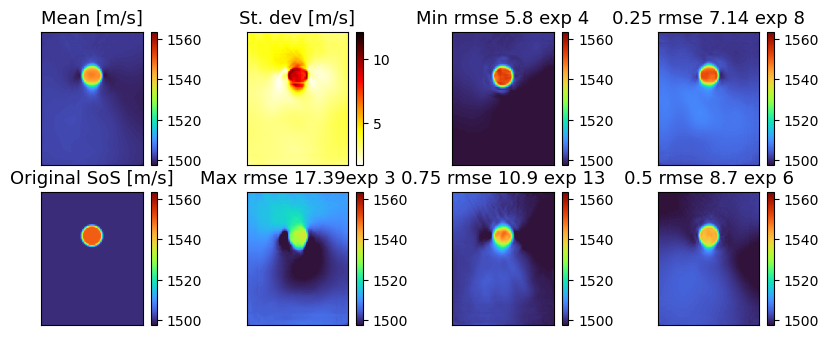

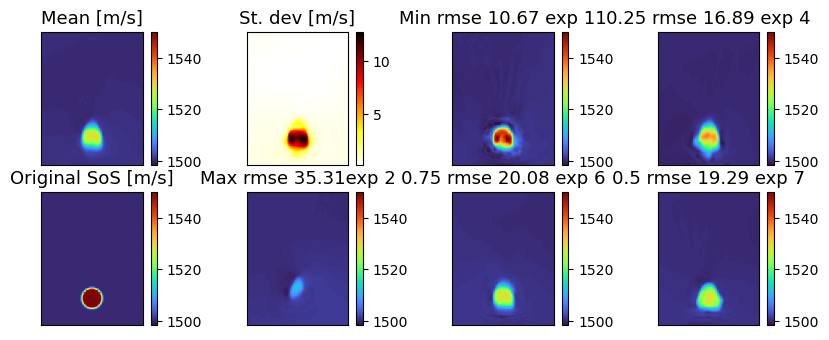

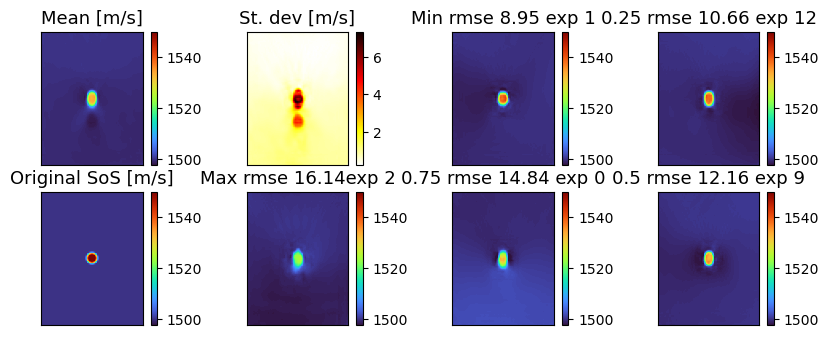

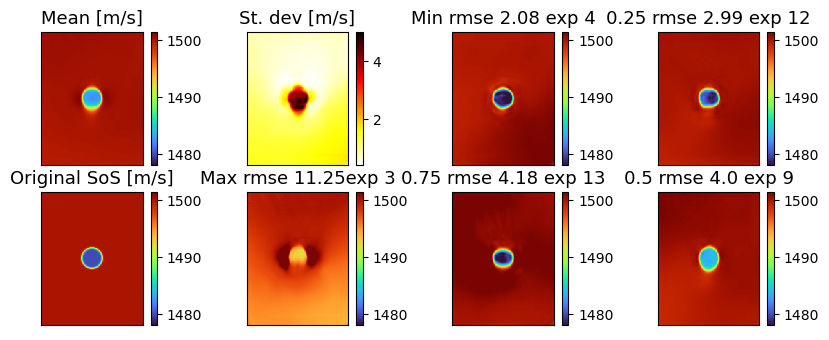

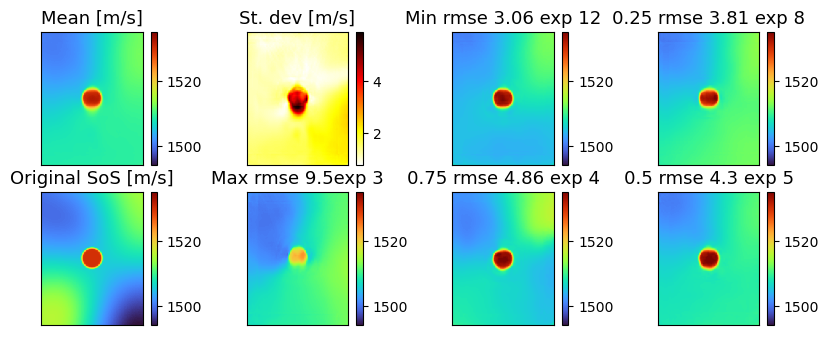

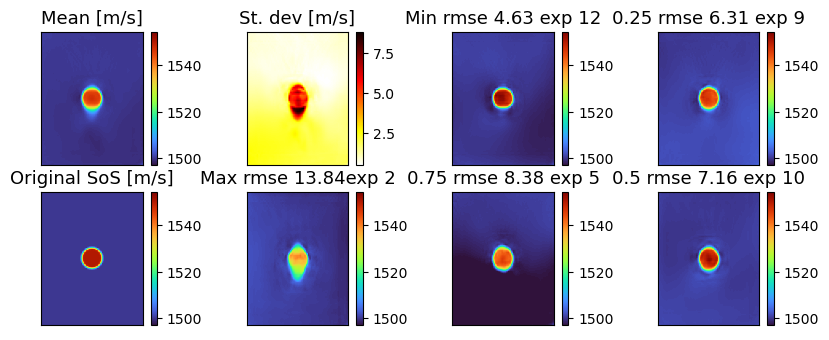

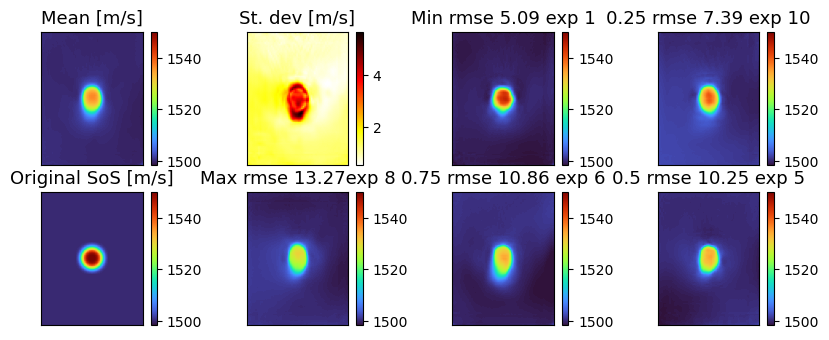

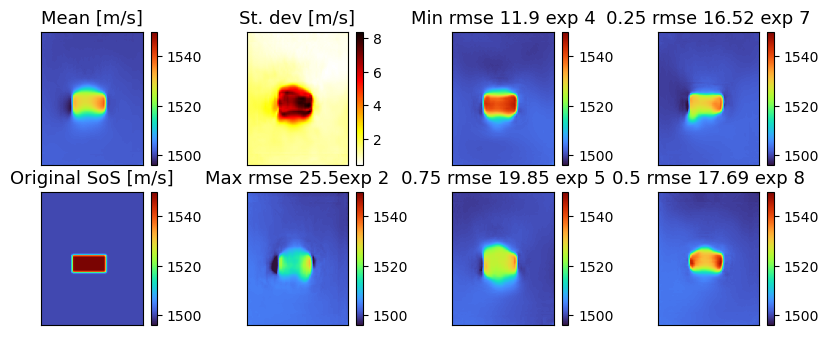

In [15]:
"""
Obtaining qualitative images of the samples
"""
sample_plots(experiment,8, mat, uncert, vn)

### Plotting uncertainty overall qualitative results

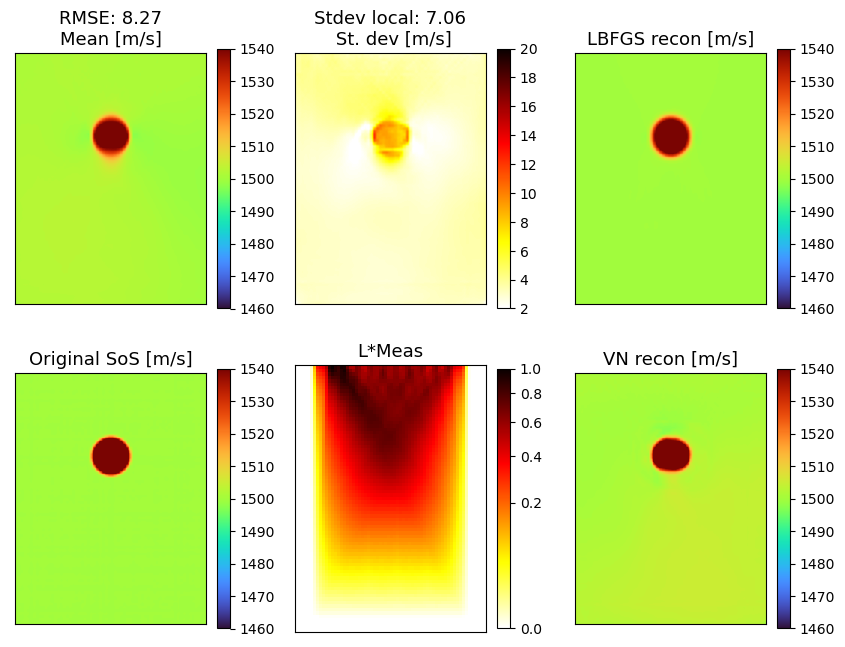

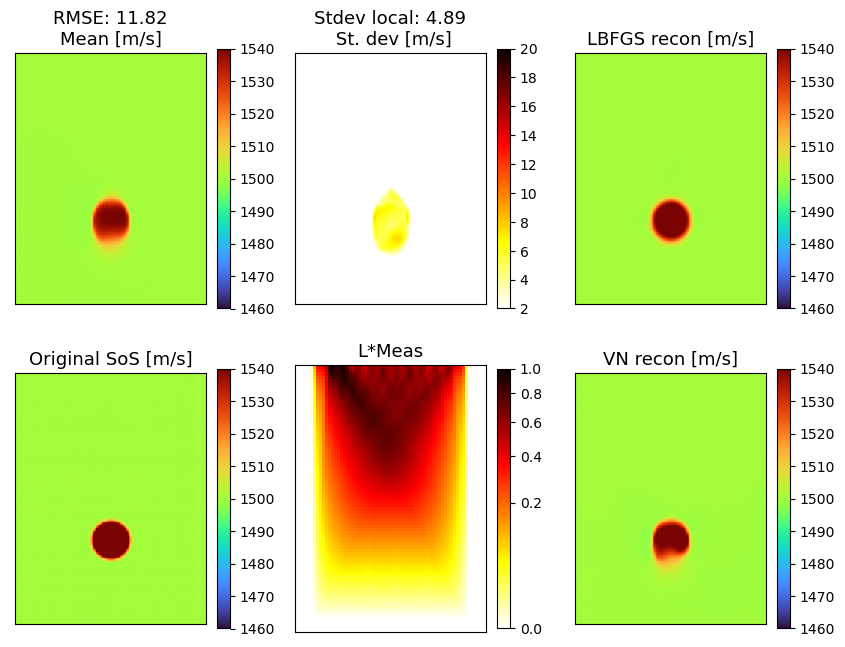

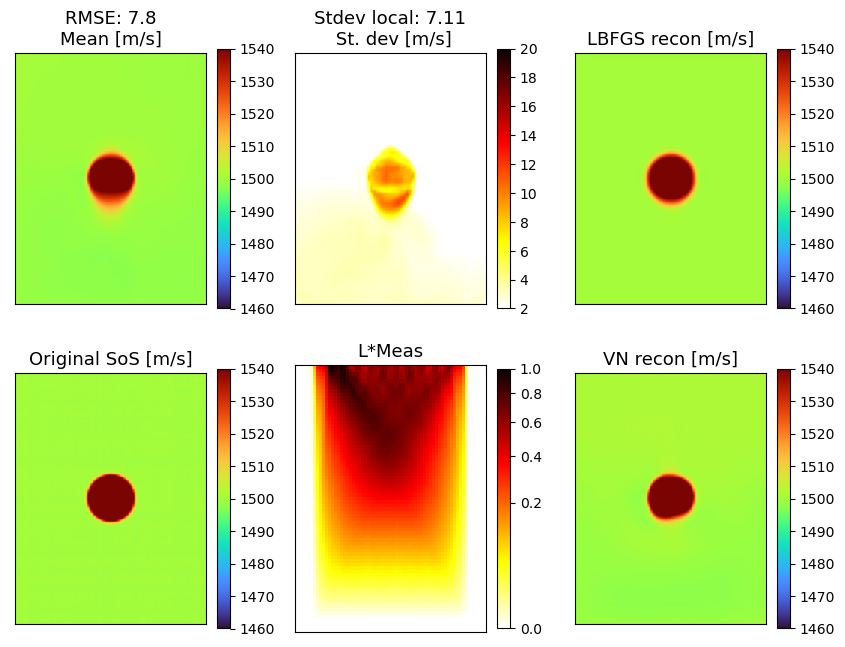

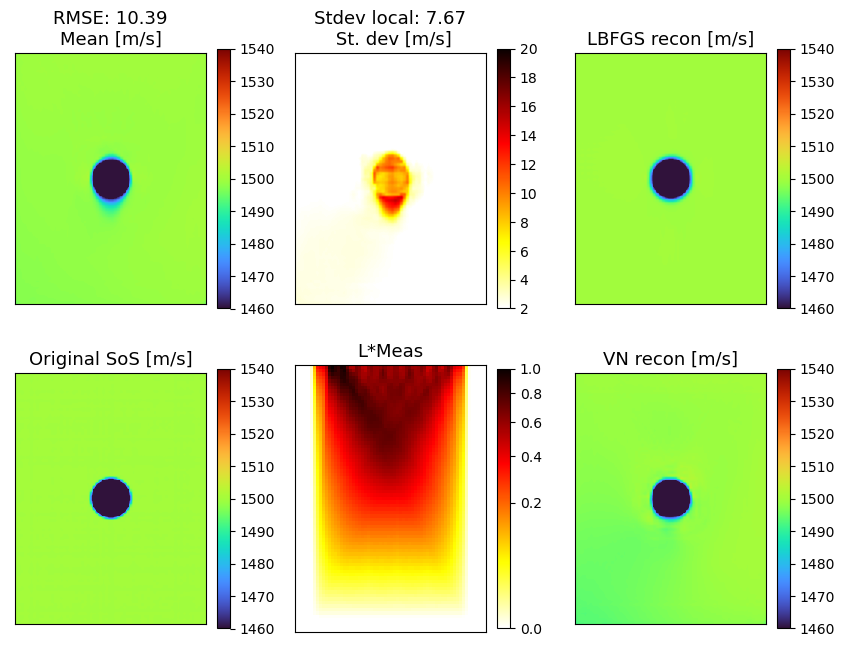

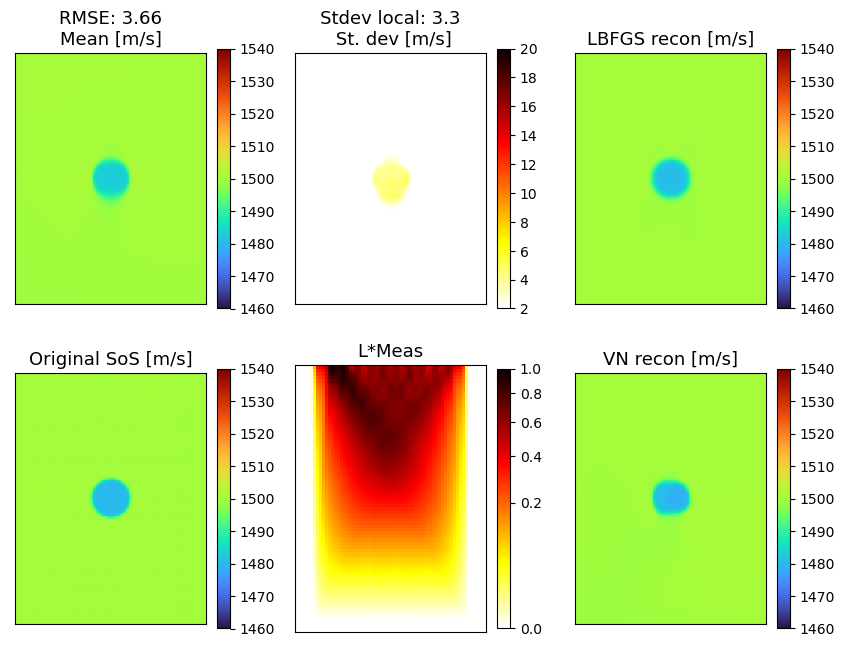

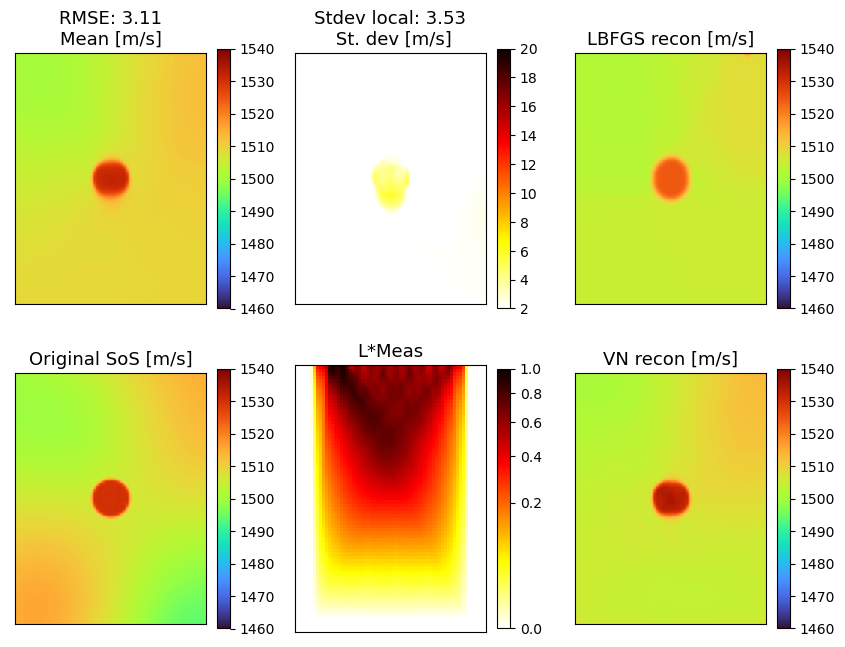

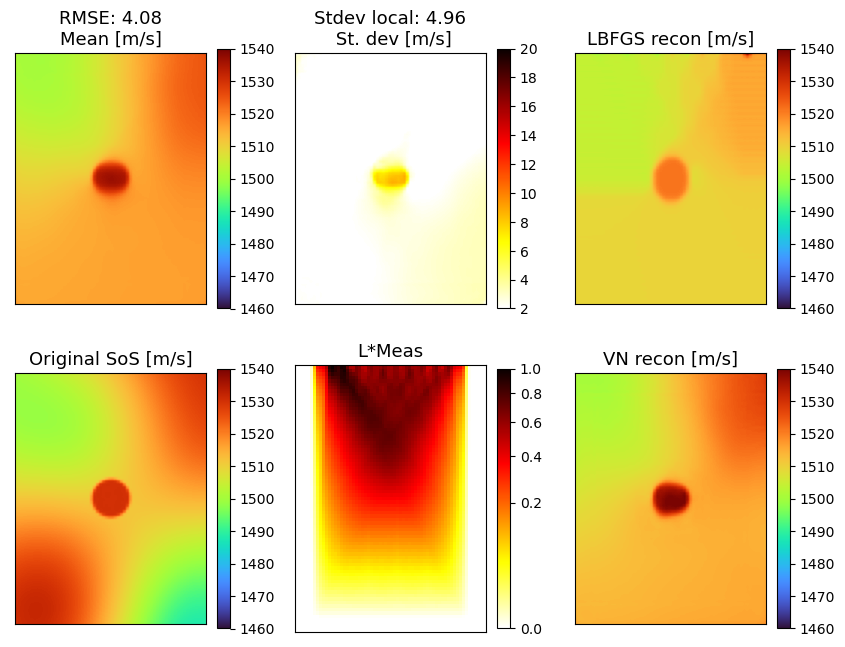

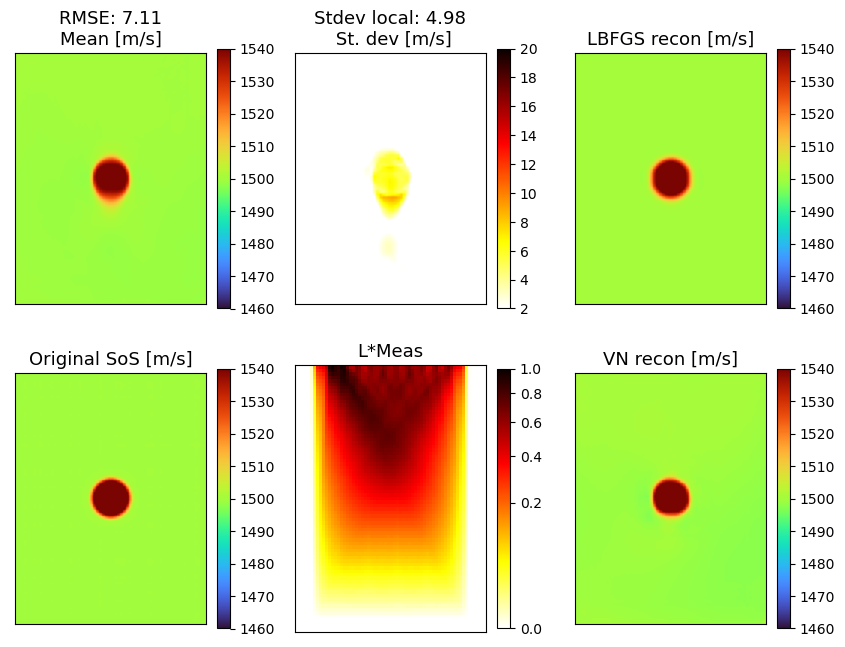

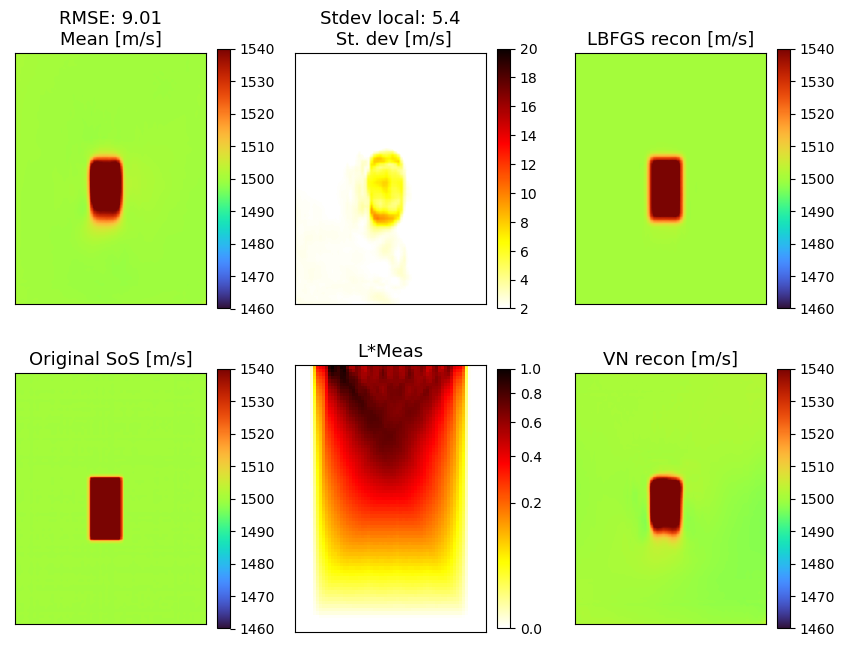

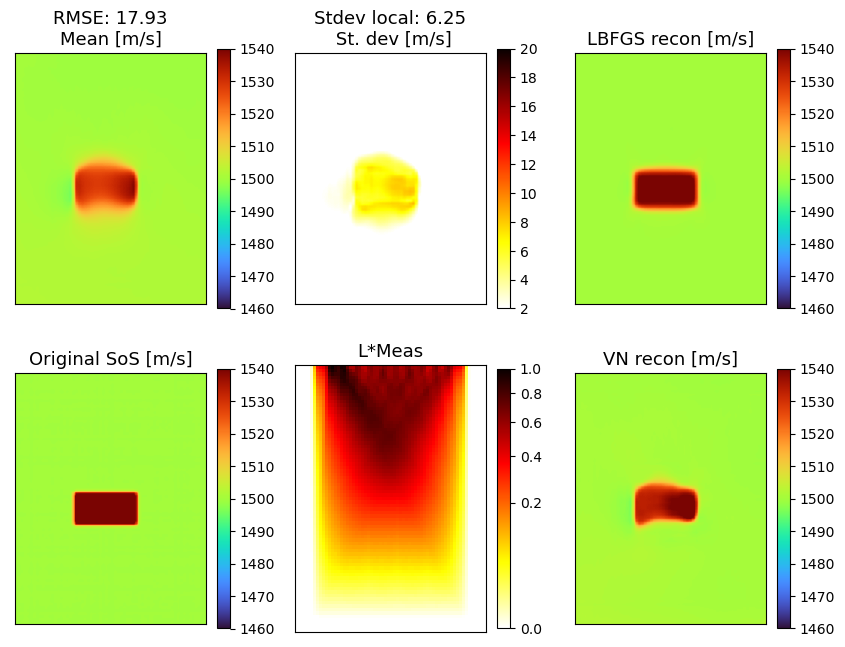

In [16]:
"""
Plotting images corresponding to: Mean reconstruction, uncertainty, LBFGS reconstruction, 
plain VN SoS, original ground truth and confidence map with labeled RMSE and local uncertainty
"""
uncert = plotting_all(experiment,uncert, exps[exp], titles_drop[0], mat, vn, lbfgs_recon, docs[type] ,True,
                        #uncert['mean'].shape[0])
                        10)

### Plotting results

#### Plotting RMSE boxplots of the method vs plain VN and LBFGS

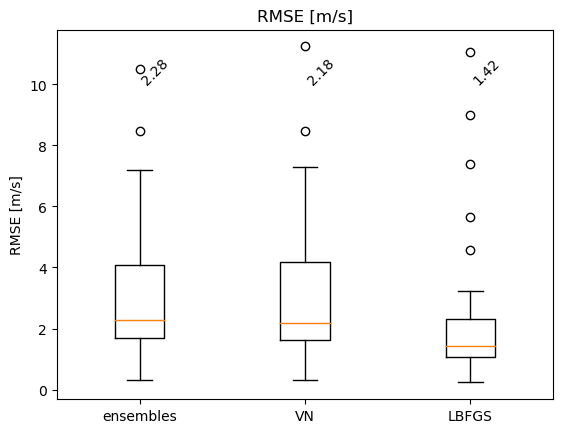

In [17]:
fig1, ax1 = plt.subplots()
ax1.set_title('RMSE [m/s]')
ax1.set_ylabel('RMSE [m/s]')
ax1.boxplot(RMSEdrop_tot)
ax1.set_xticklabels(titles)
for i in range(len(RMSEdrop_tot)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop_tot[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
ax1.tick_params()
plt.show()

#### Plotting correlations of RMSE with the local and global uncertainty

In [18]:
stdevs_mean = stdevs_mean.tolist()
dels = np.where(np.isnan(np.asarray(stdevs)))[0] #To ignore the frames without an inclusion in the computation
while not dels.size == 0:
    del RMSEdrop[0][dels[0]]
    del stdevs_mean[dels[0]]
    del stdevs[dels[0]]
    dels = np.where(np.isnan(np.asarray(stdevs)))[0]

CORR_stdev_mean, _ = spearmanr(np.asarray(RMSEdrop[0]), np.asarray(stdevs_mean))
CORR_stdev = spearmanr(np.asarray(RMSEdrop[0]), np.asarray(stdevs)).correlation

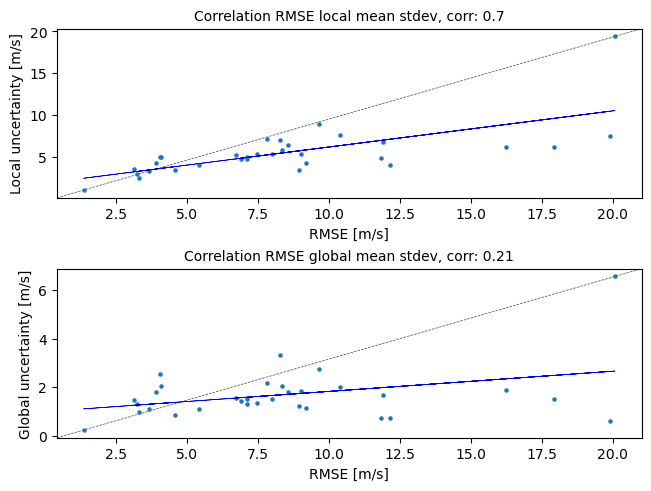

In [19]:
theta_std = np.polyfit(RMSEdrop[0], np.asarray(stdevs), 1)
y_line_std = theta_std[1] + theta_std[0] * np.asarray(RMSEdrop[0])
theta_std_mean = np.polyfit(RMSEdrop[0], np.asarray(stdevs_mean), 1)
y_line_std_mean = theta_std_mean[1] + theta_std_mean[0] * np.asarray(RMSEdrop[0])

fig, ax = plt.subplots(2, 1, constrained_layout=True)
ax[0].scatter(RMSEdrop[0], np.asarray(stdevs), s=5)
ax[0].plot(RMSEdrop[0], y_line_std, 'b', linewidth=0.5)
ax[0].set_title('Correlation RMSE local mean stdev, corr: ' + str(np.around(CORR_stdev, decimals=2)), fontsize=10)
ax[0].set_ylabel('Local uncertainty [m/s]')
ax[0].set_xlabel('RMSE [m/s]')
lims = [ax[0].get_xlim(), ax[0].get_ylim()]
ax[0].plot(lims[0], lims[1], 'k--', alpha=0.75, zorder=0, linewidth=0.5)
ax[0].set_xlim(lims[0])
ax[0].set_ylim(lims[1])
ax[1].scatter(RMSEdrop[0], np.asarray(stdevs_mean), s=5)
ax[1].plot(RMSEdrop[0], y_line_std_mean, 'b', linewidth=0.5)
ax[1].set_title('Correlation RMSE global mean stdev, corr: ' + str(np.around(CORR_stdev_mean, decimals=2)), fontsize=10)
lims = [ax[1].get_xlim(), ax[1].get_ylim()]
ax[1].plot(lims[0], lims[1], 'k--', alpha=0.75, zorder=0, linewidth=0.5)
ax[1].set_ylabel('Global uncertainty [m/s]')
ax[1].set_xlabel('RMSE [m/s]')
ax[1].set_xlim(lims[0])
ax[1].set_ylim(lims[1])
plt.show()